# Use Case Tutorial: Retail Demand Forecasting using DataRobot Python API and Time-series Helper Functions

## This notebook will walk through brief data prep and EDA, data quality checks, preparing the data for modeling, clustering the different series, and modeling in DataRobot

### In this use case, we are forecasting Candy sales for the next month from a single store. The store owner wants to decide which types and how much of each candy to stock for the next month, and potentially limit inventory to only high sales items. We have over 2 years of historical transaction data from the candy store. (Note on data: data does not actually correspond candy sales, but original sales data was anonymized and converted to candy sales to protect data source privacy)

In [1]:
# import packages
import datarobot as dr
import datarobot_ts_helpers as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import os
import re 
from importlib import reload
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set pandas configuration to show all columns
pd.set_option('display.max_columns', None)

### Connect to DataRobot Python API Client

In [3]:
# configure connection to DataRobot
# endpoint and API-token are stored in a config file

# US-server
dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig.yaml', connect_timeout= 50000)

# EU-server
# dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig_eu.yaml', connect_timeout= 50000)


---------------

# Import Dataset

### This merged dataset was created from several SQL tables in the Demand_forecasting_tutorial_data_from_SQL.ipynb notebook. For details on that process, see that notebook.

### Here, we will start with a flat .csv file that contains most of our fields of interest on a non-aggregated level

In [4]:
# import datasets
dtypes = {'invoice': 'int64', 'day': 'str','item_name': 'str', 'item_size': 'str', 'transaction': 'str' 
          , 'category': 'str', 'store_category': 'str', 'package_id': 'str', 'campaign': 'str', 'qty': 'float64'
          , 'unit_price': 'float64', 'sale_amount': 'float64'}
date_time_cols = ['date', 'time']

# create a Pandas DataFrame
df = pd.read_csv('data/clean_sales_2.csv', index_col = 0, dtype= dtypes, parse_dates= date_time_cols)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87788 entries, 0 to 88479
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice         87788 non-null  int64         
 1   date            87788 non-null  datetime64[ns]
 2   day             87788 non-null  object        
 3   time            87788 non-null  datetime64[ns]
 4   item_name       87788 non-null  object        
 5   item_size       87788 non-null  object        
 6   transaction     87788 non-null  object        
 7   category        87788 non-null  object        
 8   store_category  87788 non-null  object        
 9   package_id      87707 non-null  object        
 10  campaign        87787 non-null  object        
 11  qty             87788 non-null  float64       
 12  unit_price      87788 non-null  float64       
 13  sale_amount     87788 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(8)


In [6]:
# in order to save space and increase processing speed, we can reduce the size of file by changing 64 to 32 bit
# this could have been set on import, but for simplicity is performed here
df = ts.dataset_reduce_memory(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87788 entries, 0 to 88479
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice         87788 non-null  int32         
 1   date            87788 non-null  datetime64[ns]
 2   day             87788 non-null  object        
 3   time            87788 non-null  datetime64[ns]
 4   item_name       87788 non-null  object        
 5   item_size       87788 non-null  object        
 6   transaction     87788 non-null  object        
 7   category        87788 non-null  object        
 8   store_category  87788 non-null  object        
 9   package_id      87707 non-null  object        
 10  campaign        87787 non-null  object        
 11  qty             87788 non-null  float32       
 12  unit_price      87788 non-null  float32       
 13  sale_amount     87788 non-null  float32       
dtypes: datetime64[ns](2), float32(3), int32(1), object(8)


#### Only a small reduction in space for this small dataset, but it might have a substantial impact on larger datasets


--------------------------

# Exploratory Data Analysis

### Lets briefly explore this dataset

In [8]:
df.head()

invoice       date  day                time                 item_name  \
0    11552 2017-12-31  Sun 2020-10-06 18:32:00                 Baby Ruth   
1    11552 2017-12-31  Sun 2020-10-06 18:32:00          Hersheys Krackel   
2    11550 2017-12-31  Sun 2020-10-06 17:56:00                 Milky Way   
3    11548 2017-12-31  Sun 2020-10-06 17:16:00  Reeses Peanut Butter cup   
4    11548 2017-12-31  Sun 2020-10-06 17:16:00        Peanut butter M&Ms   

   item_size transaction category store_category  package_id         campaign  \
0  Full Size        Good   Retail         Type_B  1700002136  discount_type_1   
1  Full Size        Good   Retail         Type_B  1700002137  discount_type_1   
2  Full Size        Good   Retail         Type_B  1700002138  discount_type_1   
3  Full Size        Good   Retail         Type_B  1700002153  discount_type_1   
4  Full Size        Good   Retail         Type_B  1700002141  discount_type_1   

    qty  unit_price  sale_amount  
0  2.00        2.70         5.40  
1  2.01        2.70         5.43  
2  3.91        1.85         7.23  
3  3.96        2.13         8.43  
4  3.96        2.13         8.43

### Invoice # corresponds to an individual transaction, and multiple separate items in the transaction are represented on multiple rows.

### On average, how many items are purchased in a transaction?

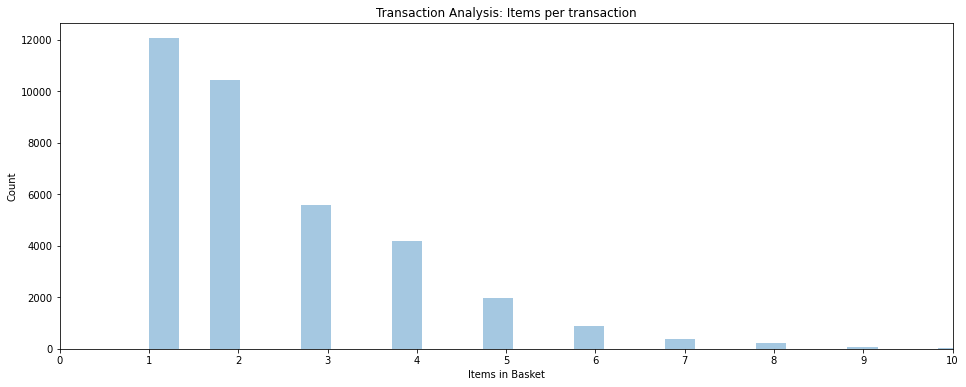

In [9]:
# plot the distribution of items in each transaction
plt.figure(figsize= (16, 6))
sns.distplot(df.groupby('invoice').count()['sale_amount'], kde= False)
plt.xlim(0, 10)
plt.xticks([x for x in range(0,11)])
plt.xlabel('Items in Basket')
plt.ylabel('Count')
plt.title('Transaction Analysis: Items per transaction');

### How many transactions occur daily for most and least common items?

In [10]:
# aggregate data to date and item names
data = df.groupby(['date', 'item_name']).count().reset_index()

# best and worst selling items
data_high = data.groupby('item_name').sum().nlargest(10, 'sale_amount').reset_index()['item_name'].values.tolist()
data_low = data.groupby('item_name').sum().nsmallest(10, 'sale_amount').reset_index()['item_name'].values.tolist()

Text(0.5, 1.0, 'Frequency of daily transactions for most-sold items')

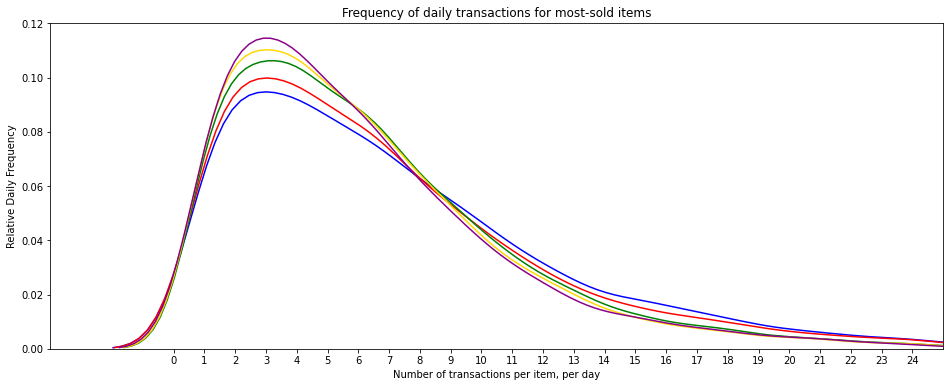

In [11]:
# plot the frequency of daily transactions for the top-5 best selling candy items
plt.figure(figsize= (16, 6))
sns.distplot(data[data['item_name'].isin(data_high[0:])]['sale_amount'], hist= False, kde= True, color="blue", label=data_high[0])
sns.distplot(data[data['item_name'].isin(data_high[1:])]['sale_amount'], hist= False, kde= True, color="red", label=data_high[1])
sns.distplot(data[data['item_name'].isin(data_high[2:])]['sale_amount'], hist= False, kde= True, color="green", label=data_high[2])
sns.distplot(data[data['item_name'].isin(data_high[3:])]['sale_amount'], hist= False, kde= True, color="gold", label=data_high[3])
sns.distplot(data[data['item_name'].isin(data_high[4:])]['sale_amount'], hist= False, kde= True, color="darkmagenta", label=data_high[4])
plt.xlim(-4, 25)
plt.xticks([x for x in range(0,25)])
plt.ylabel('Relative Daily Frequency')
plt.xlabel('Number of transactions per item, per day')
plt.title('Frequency of daily transactions for most-sold items')

Text(0.5, 1.0, 'Frequency of daily transactions for least-sold items')

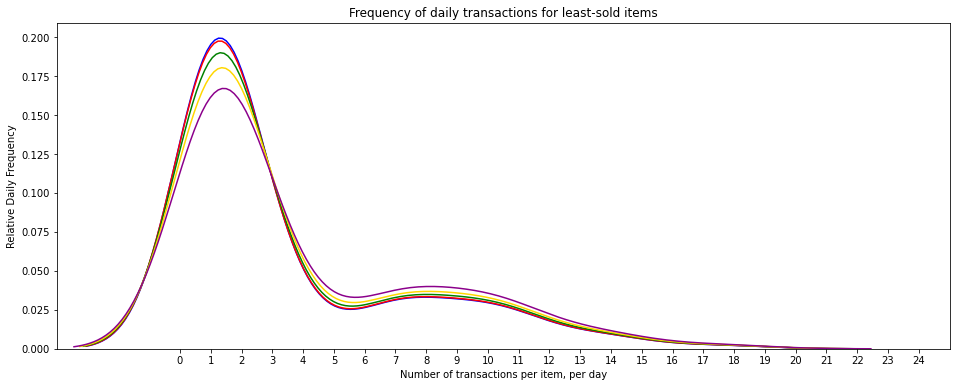

In [12]:
# plot the frequency of daily transactions for the bottom-5 worst selling candy items
plt.figure(figsize= (16, 6))
sns.distplot(data[data['item_name'].isin(data_low[0:])]['sale_amount'], hist= False, kde= True, color="blue", label=data_low[0])
sns.distplot(data[data['item_name'].isin(data_low[1:])]['sale_amount'], hist= False, kde= True, color="red", label=data_low[1])
sns.distplot(data[data['item_name'].isin(data_low[2:])]['sale_amount'], hist= False, kde= True, color="green", label=data_low[2])
sns.distplot(data[data['item_name'].isin(data_low[3:])]['sale_amount'], hist= False, kde= True, color="gold", label=data_low[3])
sns.distplot(data[data['item_name'].isin(data_low[4:])]['sale_amount'], hist= False, kde= True, color="darkmagenta", label=data_low[4])
plt.xlim(-4, 25)
plt.xticks([x for x in range(0,25)])
plt.ylabel('Relative Daily Frequency')
plt.xlabel('Number of transactions per item, per day')
plt.title('Frequency of daily transactions for least-sold items')


------------------------

# Data Manipulation

### The data needs to be aggregate for use in modeling. Aggregating to daily total sold for each item will work.

#### We can either import the aggregated dataset we prepared in the Demand_forecasting_tutorial_data_prep_from_SQL.ipynb notebook, or perform the aggregation here

In [13]:
# import already aggregated data
df_agg = pd.read_csv('data/aggregate_sales.csv', index_col = 0)


# this aggregated data set already contains information about the local market, so that doesn't need to be joined in
# we can change the variable name so it will work properly in the subsequent cells
df2 = df_agg.copy

### Briefly, the aggregation is also shown below:

In [14]:
# for this dataset, this cell will require ~ 1-2 min to run
df_agg = ts.aggregate_df(df, ['date', 'item_name'], 
                      string_columns= ['package_id', 'campaign'], 
                      numeric_columns= ['qty', 'unit_price', 'sale_amount'], 
                      ignore_columns= ['day', 'store_category', 'category', 'transaction'])

    # '''
    # Aggregates individual data by designated single or multi-level aggregation columns and performs aggregation for different column types.
    # -----
    # inputs: 
    # df:(Pandas DataFrame),

    # aggregators: list of str
    #     columnms names to be used for aggregation
    # string_columns: (list),

    # numeric_columns: (list), 

    # ignore_columns: (list)

    # Returns
    # -------
    # output: out_df (Pandas DataFrame)
    # '''


Processing 2 string columns:
*** Processing package_id 1/2 ***
*** Processing campaign 2/2 ***

Processing 3 numeric columns:
*** Processing qty 1/3 ***
*** Processing unit_price 2/3 ***
*** Processing sale_amount 3/3 ***

Processing 4 simple columns:
*** Processing day 1/4 ***
*** Processing store_category 2/4 ***
*** Processing category 3/4 ***
*** Processing transaction 4/4 ***


In [15]:
# the new dataframe shows the aggregated statistics for all columns
df_agg.head()

date                 item_name package_id_min package_id_max  \
0 2017-02-03              3 Musketeers     1700000005     1700000005   
1 2017-02-03          Hersheys Krackel     1700000004     1700000004   
2 2017-02-03        Milky Way Midnight     1700000007     1700000007   
3 2017-02-03         Reeses Miniatures     1700000008     1700000008   
4 2017-02-03  Reeses Peanut Butter cup     1700000006     1700000006   

   package_id_unique     campaign_min     campaign_max  campaign_unique  \
0                  1  discount_type_1  discount_type_1                1   
1                  1  discount_type_1  discount_type_1                1   
2                  1  discount_type_1  discount_type_1                1   
3                  1  discount_type_1  discount_type_1                1   
4                  1  discount_type_1  discount_type_1                1   

   qty_min  qty_mean  qty_max  qty_stdev  qty_unique  qty_sum  unit_price_min  \
0     0.56      0.56     0.56        NaN         1.0     0.56             0.0   
1     0.56      0.56     0.56        NaN         1.0     0.56             0.0   
2     0.56      0.56     0.56        NaN         1.0     0.56             0.0   
3     0.56      0.56     0.56        NaN         1.0     0.56             0.0   
4     0.56      0.56     0.56        NaN         1.0     0.56             0.0   

   unit_price_mean  unit_price_max  unit_price_stdev  unit_price_unique  \
0              0.0             0.0               NaN                1.0   
1              0.0             0.0               NaN                1.0   
2              0.0             0.0               NaN                1.0   
3              0.0             0.0               NaN                1.0   
4              0.0             0.0               NaN                1.0   

   unit_price_sum  sale_amount_min  sale_amount_mean  sale_amount_max  \
0             0.0              0.0               0.0              0.0   
1             0.0              0.0               0.0              0.0   
2             0.0              0.0               0.0              0.0   
3             0.0              0.0               0.0              0.0   
4             0.0              0.0               0.0              0.0   

   sale_amount_stdev  sale_amount_unique  sale_amount_sum  day store_category  \
0                NaN                 1.0              0.0  Fri         Type_B   
1                NaN                 1.0              0.0  Fri         Type_B   
2                NaN                 1.0              0.0  Fri         Type_B   
3                NaN                 1.0              0.0  Fri         Type_B   
4                NaN                 1.0              0.0  Fri         Type_B   

  category transaction  aggregated_total_count  
0   Retail    Canceled                       1  
1   Retail    Canceled                       1  
2   Retail    Canceled                       1  
3   Retail    Canceled                       1  
4   Retail    Canceled                       1

### Incorporate Information about the local Market sales for candy

In [16]:
market_df = pd.read_csv('data/aggregate_market_total_sales.csv', index_col= 0)

In [17]:
# reported information is retroactively created for the month, so wouldn't be known at the start of the month
# shift these dates to the end of the month
market_df['Month_end'] = pd.to_datetime(market_df['Month']) + MonthEnd(1)

In [18]:
# merge this monthly data into the aggregated sales data
df2 = df_agg.merge(market_df[['Month_end', 'category_type', 'metro_area', 'county_1', 'total_market_sales']], how= 'left', left_on= ['date','store_category'], right_on= ['Month_end','category_type'])
df2.drop(['Month_end', 'category_type'], axis= 1, inplace= True)


----------------

# Project Settings

### Configure the settings to be used in the Time Series problem in DataRobot

In [19]:
# Set default values
target= 'sale_amount_sum'
date_col = 'date'
series_id = 'item_name'
kia = None # No columns known in advance for this dataset!
num_backtests = 3
validation_duration = 30 # want to predict 1-month sales
holdout_duration = 30 
disable_holdout = False
metric = 'RMSE' # what makes most sense in this case?
use_time_series = True
fd_start = 1
fd_end = 31 # forecasting sales for the next month
fdw_start = -28 # we should iterate on this
fdw_end = 0
max_date = df_agg['date'].max() - pd.DateOffset(31)

# create Time Series settings
ts_settings = {'max_date':max_date, 'known_in_advance':kia, 'num_backtests':num_backtests, 
               'validation_duration':validation_duration, 'holdout_duration':holdout_duration,
               'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end}

## Metrics in time series projects:

- if you want a model that is extremely penalizing of extreme values, use a 'squared' metric (RMSE) to heavily penalize extreme values
- Seasonally adjusted metrics -> SMAPE, MASE?
- Baseline-relevant metrics? 

### Without knowing what the distribution of the data looks like, it is difficult to know what the 'best' project-metric is. Reviewing the metric descriptions can help, but that may be better understood after some initial modeling is completed.

(Internal only) DataRobot Metrics Explained: https://docs.google.com/document/d/1uo6XeF8Ym4ovdpJ5VWxMyblS3OzHv9BslwTKYufgCRw/edit#

-------------------

# Check the data quality

In [20]:
ts_describe = ts.DataQualityCheck(df2, ts_settings)

    # """
    # A class used to capture summary stats and data quality checks prior to uploading time series data to DataRobot

    # Attributes:
    # -----------
    # df : DataFrame
    #     time series data, including a date column and target variable at a minimum
    # settings : dict
    #     definitions of date_col, target_col, series_id and time series parameters
    # stats : dict
    #     summary statistics generated from `calc_summary_stats`
    # duplicate_dates : int
    #     duplicate dates in the time series date_col
    # series_timesteps : series
    #     steps between time units for each series_id
    # series_max_gap : series
    #     maximum time gap per series
    # series_lenth : series
    #     length of each series_id
    # series_pct : series
    #     percent of series with complete time steps
    # irregular : boolean
    #     True if df contains irregular time series data
    # series_negative_target_pct : float
    #     Percent of target values that are negative

    # Methods:
    # --------
    # calc_summary_stats(settings, df)
    #     generates a dictionary of summary statistics
    # calc_time_steps(settings, df)
    #     calculate time steps per series_id
    # hierarchical_check(settings, df)
    #     check if time series data passes heirarchical check
    # zero_inflated_check(settings, df)
    #     check if target value contains zeros
    # negative_values_check(settings, df)
    #     check if target value contains negative values
    # time_steps_gap_check(settings, df)
    #     check if any series has missing time steps
    # irregular_check(settings, df)
    #     check is time series data irregular
    # """

Running all data quality checks...

There are 14271 rows and 34 columns
There are 50 series
The data spans from  2017-02-03 00:00:00 to 2019-05-21 00:00:00
Data fails hierarchical check! No hierarchical blueprints will run.
The minimum target value is zero. Zero-Inflated blueprints will run.
 70.00% of the series appeared after the start of the training data
 44.00% of the series were removed before the end of the training data
No duplicate timestamps detected within any series
No leading or trailing zeros detected within series
98.00% of series have at least one missing time step.
0.00% of the rows are missing a target value
0.00% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Series are irregularly spaced. Projects will only be able to run in row-based mode!
Detected periodicity: ['weekly', 'yearly']


## Many series are irreguarly spaced, and there are short series. This might cause issues later on

#### Lets think about the spacing of values and if there is a reason there are missing values...

#### - We know this is a retail dataset, and days on which there are no transactions for an item will not be included in the dataset. We can use this data in 'row-based' mode, but that means that expected seasonal characteristics (weekly effects) but not be derived or discovered in the data.
#### - In this case, we want to fill these 'missing not at random zero values' that will represent a entry where nothing occured for any given series.
#### - For sporadic missing values ('missing at random'), it may be better to impute the missing values (with either a mean or knn imputing strategy)
#### - When possible, it is extremely helpful to understand why dates or values may be missing from the data as this can inform your strategy for dealing with these missing values.

### Here, we know that this dataset is expected to contain many values both because each product doesn't sell every day, and because series go on and off the market.

In [21]:
training = ts.fill_missing_dates(df2, ts_settings)

    # """
    # Insert rows with np.nan targets for series with missing timesteps between the series start and end dates

    # df: pandas df
    # ts_settings: dictionary of parameters for time series project
    # freq: project time unit and timestep
    # Returns:
    # --------
    # pandas df with inserted rows

    # """

In [22]:
# Rerun our data quality check
ts_describe = ts.DataQualityCheck(training, ts_settings)

Running all data quality checks...

There are 22371 rows and 34 columns
There are 50 series
The data spans from  2017-02-03 00:00:00 to 2019-05-21 00:00:00
Data fails hierarchical check! No hierarchical blueprints will run.
The minimum target value is zero. Zero-Inflated blueprints will run.
 70.00% of the series appeared after the start of the training data
 44.00% of the series were removed before the end of the training data
No duplicate timestamps detected within any series
No leading or trailing zeros detected within series
0.00% of series have at least one missing time step.
36.21% of the rows are missing a target value
0.00% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Timesteps are regularly spaced. You will be able to run projects in either time-based or row-based mode
Detected periodicity: ['weekly', 'yearly']


### 1. Notice those warnings about new series and series that end before prediction time. We'll see that come back and need to be addressed later in the modeling process

### 2. After adding missing dates, we now have missing target values. What is the right approach to deal with this?
#### - Leave these as missing and let DataRobot handle this. If left empty, DataRobot will fill the missing target values using the baseline model as a reference.
#### - Fill those zero-days with zero-value for the target.
#### - Use the previous day's target value (lagged value). This is difficult if we have many missing days and effectively 'weights' rows preceeding a missing date. (pd.ffill() makes this easy). This is potentially what DataRobot will do, but depending on the baseline model DataRobot might fill will a different lagged value (i.e. value last week on that day).
#### - Use a rolling window statistic (mean, median, etc) and impute the missing target values.
#### - Use the mean over the entire series history and impute missing values with the mean.

### Each approach will have benefits and drawbacks, and the best approach likely depends on the specifics of the use case


### In this case, those dates should be zeros as there were no sales on those filled dates. 

In [23]:
# lets fill those zero-values
training['sale_amount_sum'] = training['sale_amount_sum'].fillna(0)

## We want to save some of this data to use later for post-deployment predictions and monitoring. Lets split that off now

In [24]:
# split the data for 'training' and larger use as predictions on 'new data'
training_data = training[training['date'] < (training['date'].max() - pd.DateOffset(30))]
test_data = training[training['date'] >= (training['date'].max() - pd.DateOffset(30))]

training = training_data.copy()

In [25]:
# write to file for simplicity
training_data.to_csv('data/data_for_modeling.csv')
test_data.to_csv('data/data_for_predictions.csv')

### Lets plot the fixed data

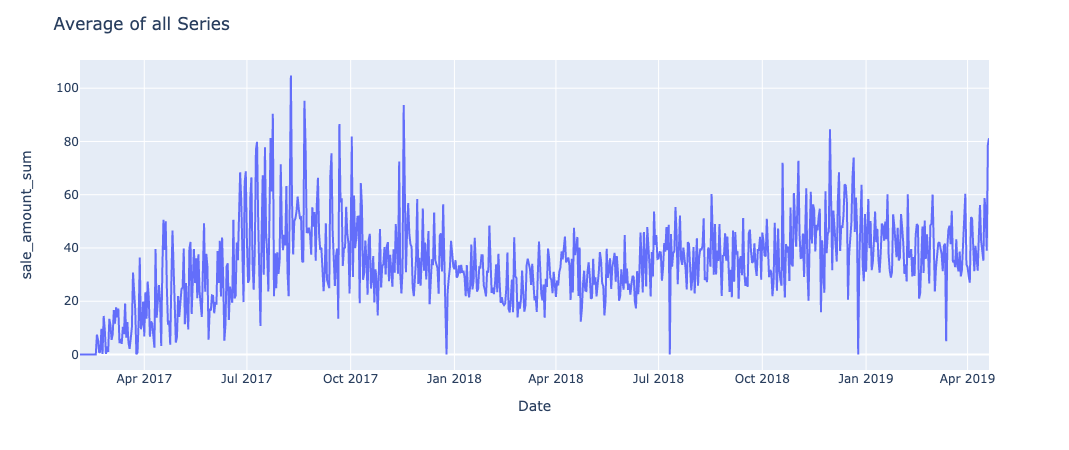

In [26]:
# Plot our average target over time
ts.plot_series_average(training, ts_settings)
# """
# Plot average series 

# df: Pandas DataFrame
#     input data
# settings: timeseries settings (ts_settings)

# """

### There is a large amount of volatility in daily sales values. Does this correspond to external events or is this an inherent feature of the data?

--------------------

# Add a calendar file

### Calendar files are often quite helpful for Time Series projects, but we don't have one for this data.

### We can automatically create a calendar file from known US Holidays.

### With calendar files, you must include calendar events in the past of the start of your training data (on period) and extending as far into the future as you would anticipate as the "working life" of your model before training

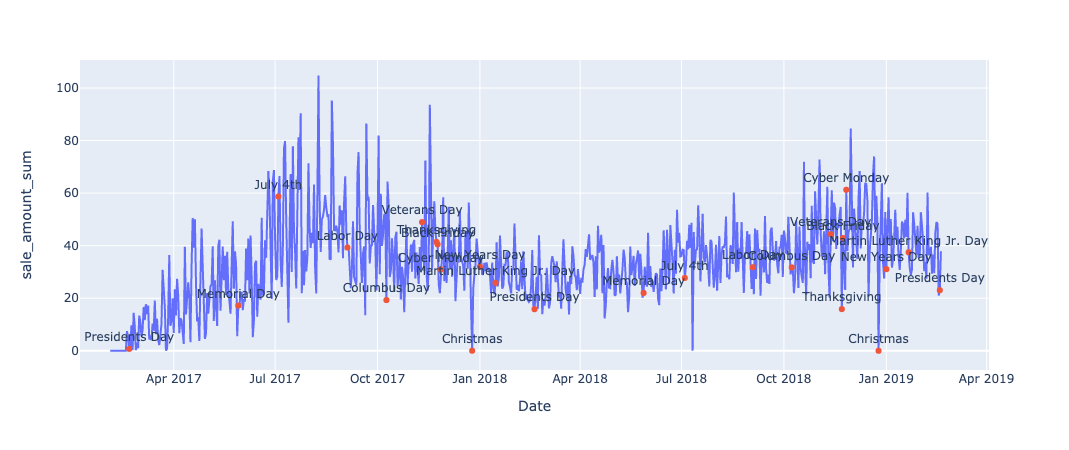

In [27]:
# Create and plot a Holiday calendar
ts.plot_ts_calendar(training, ts_settings, calendar= None)

#Note: you don't need to have an already created calendar

### Calendar doesn't seem to strongly correlate with high sales days, but still may provide value as it seems to map to low-sales days. We can include this to with the project settings.

In [28]:
# Add a calendar to our dictionary of default parameters
cal = ts.create_and_upload_ts_calendar(training, ts_settings) #if you don't specify a calendar, one will be created
ts_settings['calendar_id'] = cal.id

    # """
    # df: pandas df
    # ts_settings: dict
    #     Parameters for time series project
    # calendar: pandas df (optional)
    #     If calendar is None a new calendar will be created

    # Returns:
    # --------
    # DataRobot calendar object
    # """

Calendar file has been created
Calendar file 5f7c82fa11bc9b323fe9bc86 has been uploaded


In [29]:
# this function will create a DR-calendar multiseries object from a supplied file. 
# You need to provide a path to the saved file (filename == path), a name, an in-memory df to be used for 'calendar', and the multiseries_id as a list where the calendar column name is identical to the multiseries id column
# cal1 = ts.create_and_upload_ts_calendar(training, ts_settings, filename= 'data/multiseries_cal.csv', calendar_name= 'multiseries_cal', calendar= cal, multiseries_id= ['item_name'])
# add the calendar to the ts_settings dict
# ts_settings['calendar_id'] = cal1.id

### Evaluate some individual sales histories

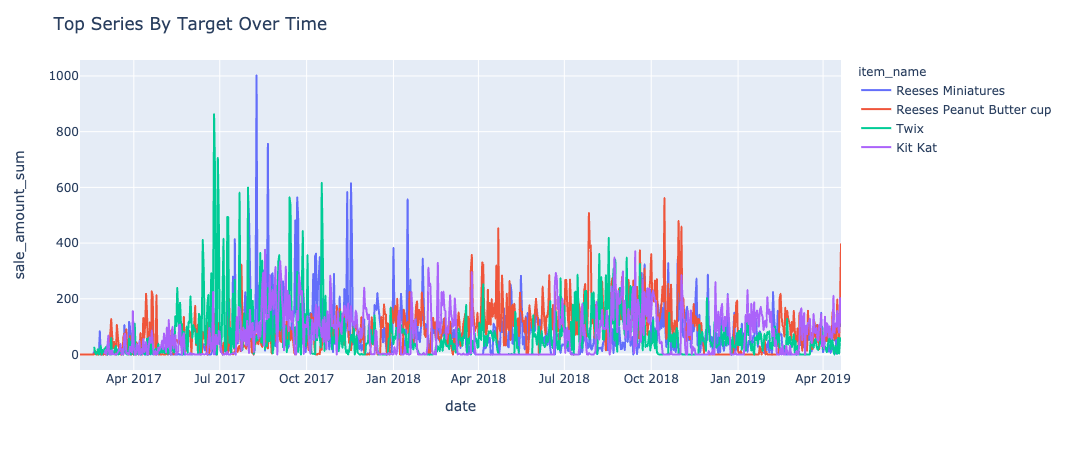

In [30]:
# Top 4 series
ts.plot_individual_series(training, ts_settings, n=4, top=True)
# """
# Plot individual series on the same chart

# n: (int) number of series to plot
# top: (boolean) whether to select the top n largest or smallest series ranked by average target value
# """

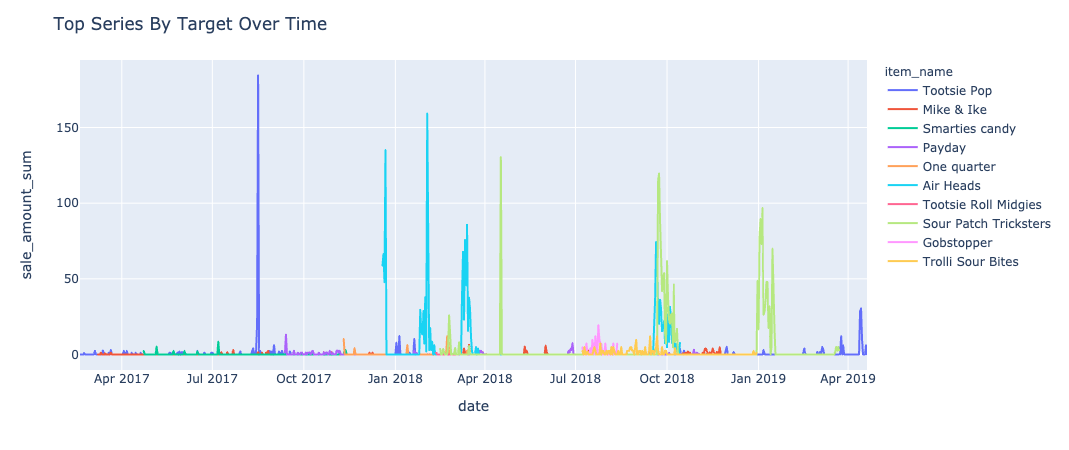

In [31]:
# Bottom 10 series
ts.plot_individual_series(training, ts_settings, n=10, top=False)

### Many series are short or discontinuous. Items go on and off the market quite regularly, and many items were tested in the market but did not remain.

-------------------
# Build Models in DataRobot

### First, the Forecast Distance (FD) and Feature Derivation Windows (FDW) need to be defined. While Forecast Distance is generally directly tied to the business use case, Feature Derivation Windows often iterated upon.

#### The DataQualityCheck function has previously identified seasonality:
``` Detected periodicity: ['weekly', 'yearly'] ```

## Project group 1: 'Demand_forecasting_tutorial_project_1'


## Need content about what things to think about when structuring a time series project


- In this dataset, we observe there are many short series.

### The DataQualityCheck function has previously identified seasonality:
``` Detected periodicity: ['weekly', 'yearly'] ```

## Comments on Feature Derivation windows:
- often FDWs are strongly correlated to business logic
- the length of FDWs will also impact how responsive your models will be to recent changes. Longer FDW will result in models that do not change as quickly with sudden changes in input variables or the target. Shorter FDW windows will be more responsive, but may over-respond to sudden changes in the short-term, but will stabilize on the 'new normal' much faster.
- FDWs may require experimentation
- As a general rule, FDWs multiples of seasonality are a good starting point



### Prediction goal
- The goal is to predict what demand for each strain would be over the next month (Forecast Distance = 30 days)

### Data availability
- In this project, we assume no known in advance data


In [34]:
# build separate projects by FD, FDW, and/or cluster
fdws = [(-28,0), (-56,0)] # typically multiples of a seasonality are a good starting point
fds = [(1,30)] # in this case, predicting one month of sales is the goal

projects = ts.create_dr_projects(training, 
                             ts_settings, 
                             prefix='Demand_forecasting_tutorial_project_1', # provide an prefix that will make it easy to search for only these projects
                             split_col= None, # this is optional, but we will see its use later
                             fdws=fdws, 
                             fds=fds, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

    # """
    # Kickoff multiple DataRobot projects

    # df: pandas df
    # ts_settings: dictionary of parameters for time series project
    # prefix: str to concatenate to start of project name
    # split_col: column in df that identifies cluster labels
    # fdws: list of tuples containing feature derivation window start and end values
    # fds: list of tuples containing forecast distance start and end values

    # Returns:
    # --------
    # List of projects

    # Example:
    # --------
    # split_col = 'Cluster'
    # fdws=[(-14,0),(-28,0),(-62,0)]
    # fds = [(1,7),(8,14)]

    # """

Kicking off 2 projects

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series ...
Project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-28_all_series was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-56_all_series ...
Project Demand_forecasting_tutorial_project_1_FD:1-30_FDW:-56_all_series was successfully built!


The following 0 projects were not built: []



In [ ]:
# details for the parameters for the above function in following cell:

In [36]:

# """
# Kickoff single DataRobot project

# df: pandas df

# ts_settings: dictionary of parameters for time series project
# (project_name) prefix: name of project

# Returns:
# --------
# DataRobot project object


# #######################
# # Get Advanced Options
# #######################
# opts = {
#     'weights': None,
#     'response_cap': None,
#     'blueprint_threshold': None,
#     'seed': None,
#     'smart_downsampled': False,
#     'majority_downsampling_rate': None,
#     'offset': None,
#     'exposure': None,
#     'accuracy_optimized_mb': None,
#     'scaleout_modeling_mode': None,
#     'events_count': None,
#     'monotonic_increasing_featurelist_id': None,
#     'monotonic_decreasing_featurelist_id': None,
#     'only_include_monotonic_blueprints': None,
# }

# ###############################
# # Create Datetime Specification
# ###############################
# time_partition = dr.DatetimePartitioningSpecification(
#     feature_settings=settings['known_in_advance'],
#     # gap_duration = dr.partitioning_methods.construct_duration_string(years=0, months=0, days=0),
#     validation_duration=dr.partitioning_methods.construct_duration_string(
#         minutes=validation_durations['minute'],
#         hours=validation_durations['hour'],
#         days=validation_durations['day'],
#     ),
#     datetime_partition_column=settings['date_col'],
#     use_time_series=settings['use_time_series'],
#     disable_holdout=settings['disable_holdout'],  # set this if disable_holdout is set to False
#     holdout_start_date=settings['holdout_start_date'],
#     holdout_duration=settings[
#         'holdout_duration'
#     ],  # set this if disable_holdout is set to False
#     multiseries_id_columns=[settings['series_id']],
#     forecast_window_start=int(settings['fd_start']),
#     forecast_window_end=int(settings['fd_end']),
#     feature_derivation_window_start=int(settings['fdw_start']),
#     feature_derivation_window_end=int(settings['fdw_end']),
#     number_of_backtests=settings['num_backtests'],
#     calendar_id=settings['calendar_id'],
#     use_cross_series_features=settings['use_cross_series_features'],
#     aggregation_type=settings['aggregation_type'],
#     cross_series_group_by_columns=settings['cross_series_group_by_columns'],
# )

# ############################
# # Get Datetime Specification
# ############################
# settings = {
#     'max_date': None,
#     'known_in_advance': None,
#     'num_backtests': None,
#     'validation_duration': None,
#     'holdout_duration': None,
#     'holdout_start_date': None,
#     'disable_holdout': False,
#     'number_of_backtests': None,
#     'backtests': None,
#     'use_cross_series_features': None,
#     'aggregation_type': None,
#     'cross_series_group_by_columns': None,
#     'calendar_id': None,
#     'use_time_series': False,
#     'series_id': None,
#     'metric': None,
#     'target': None,
#     'mode': dr.AUTOPILOT_MODE.FULL_AUTO,  # MANUAL #QUICK
#     'date_col': None,
#     'fd_start': None,
#     'fd_end': None,
#     'fdw_start': None,
#     'fdw_end': None,
# } """

## At this point, we could proceed directly to model evaluation, in the subsequent modeling notebook.

## But, in many cases we may want to break this time series problem into smaller pieces and model them separately within DataRbot. We may get better results by breaking this into more projects.

#### Data ingest limits may necessitate breaking the dataset into many DataRobot projets

#### Increased performance and model accuracy from modeling of 

### Three options should be considered, amongst others:
1. Break the Forecast Distance into smaller groups
2. Test different Feature Derivation Windows
3. Split the data by cluster and model each separately

--------------------
# Clustering Series

### For the sake of this tutorials, lets evaluate different clustering strategies. This could be performed after a first modeling round with a single DataRobot project, but is shown here directly
### It may be useful to cluster these different sales histories to identify different trends and allow different data differencing treatments to be selected. 
#### The 'add_cluster_labels' function will automatically test different numbers of clusters and can test different clustering strategies.

## Cluster strategies:
- Magnitude of series (size of target)
- Correlation of series
- Velocity of series (frequency of target)
- Zero-inflated series (lots of true zero-days?)
- build a 'generic' series for any new clusters

#### This clustering can either occur locally using 'correlation', 'pacf', or 'target' methods or using DataRobot's clustering capabilities with 'performance' or 'similarity' clustering method

Which approach should we use?
- If there are highly cyclical or rotational aspects of the data -> pacf
- Retail data -> target or correlation
- Domain expertise -> manual clustering, target, or correlation
- Want to impress other data scientist? -> 'Similarity clustering' blueprints within DataRobot (uses Dynamic Time Warping... computationally expensive and not incredibly effective but pretty cool theory)

#### The first clustering method 'correlation' relies upon the pearson correlation coefficient to see how strongly correlated individual sales series are, and assigns clusters based on highest correlation between series.

Testing 2 to 15 clusters
For n_clusters = 2, silhouette score is 0.07064130216802401
For n_clusters = 3, silhouette score is 0.05480866287521848
For n_clusters = 4, silhouette score is 0.05883047688786803
For n_clusters = 5, silhouette score is 0.05582943565863124
For n_clusters = 6, silhouette score is 0.05417583694028309
For n_clusters = 7, silhouette score is 0.05432684362452953
For n_clusters = 8, silhouette score is 0.047029026301714814
For n_clusters = 9, silhouette score is 0.057122138824776125
For n_clusters = 10, silhouette score is 0.044421206095647515
For n_clusters = 11, silhouette score is 0.06665994473525055
For n_clusters = 12, silhouette score is 0.05383649671935319
For n_clusters = 13, silhouette score is 0.04695383753374269
For n_clusters = 14, silhouette score is 0.06531146993694201
For n_clusters = 15, silhouette score is 0.055157353641486724
optimal n_clusters = 2, max silhouette score is 0.07064130216802401


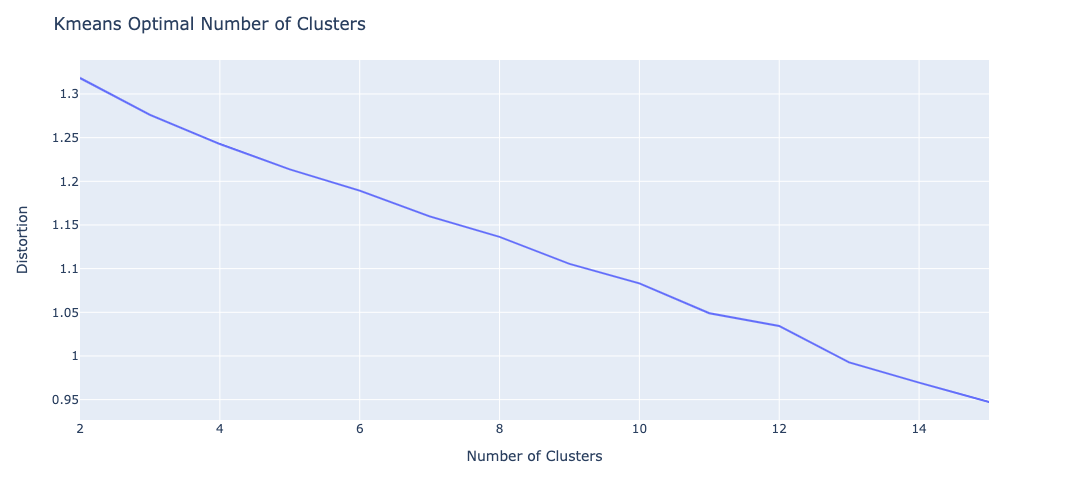

In [32]:
# Series clustering using 'correlation'
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=None
max_clusters=15
plot=True

df_w_clusters =  ts.add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=plot)

### This elbow-plot does not indicate any obvious clusters as an inflection point to indicate an optimal number of clusters. There is a VERY minor inflection at 3 clusters, lets force that number.

### Plot the results of this clustering, perhaps we can see something releveant here visually.

/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




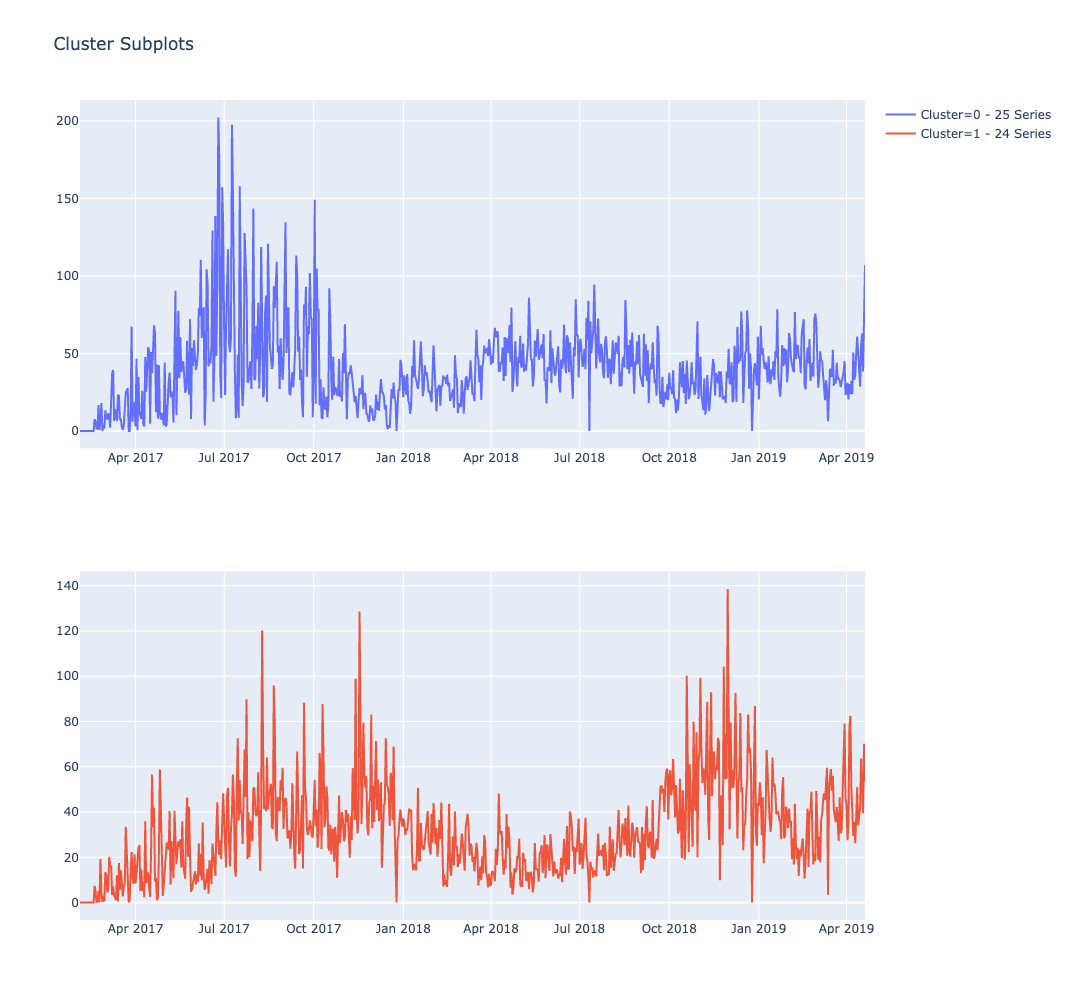

In [33]:
ts.plot_clusters(df_w_clusters, ts_settings)

### There was no 'elbow' in the plot to determine the best number of clusters, and 2 clusters were selected. This clearly doesn't work very well in this case. 


### We see that the initial clustering has done a decent job of separating clusters, but that it could be improved.

## As a note: retail data often has a 'corkscrew' or 'ram's horn' shape in a 3-dimensional PCA (or other dimensionality reduction technique) plot that corresponds to different types of sales pattern. In this smaller dataset, we don't clearly see such a pattern. 

### We may want to force a certain number of clusters, that can be done explicitly by setting an integer value for n_clusters.

In [34]:
# Series clustering
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=3
max_clusters=15
plot=True

df_w_clusters =  ts.add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=plot)



/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




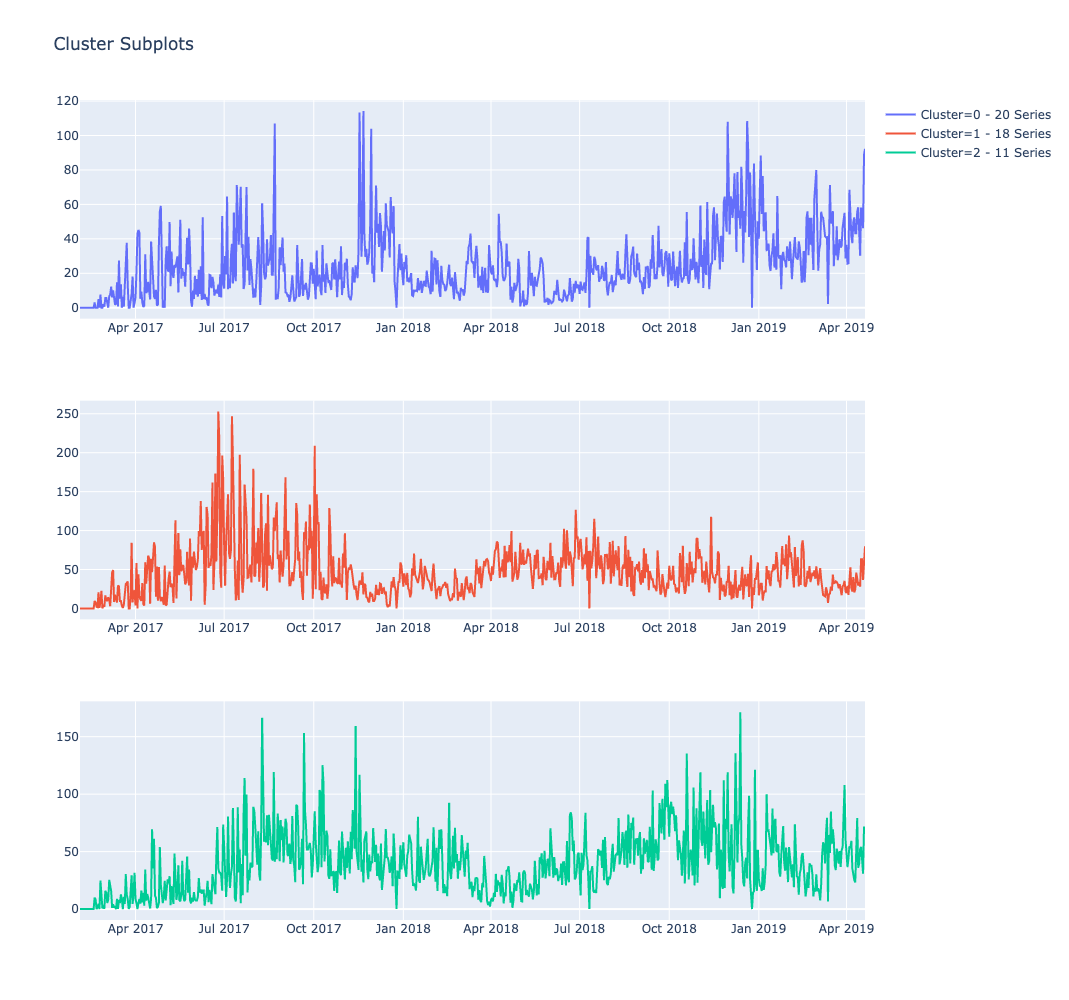

In [35]:
ts.plot_clusters(df_w_clusters, ts_settings)

### It can be difficult to know the optimal number of clusters unless there are obvious differences in the series. How can we evaluate these?

------
# Dimensionality reduction on clustered data

In [36]:
# reshape the dataframe for dimensionality reduction
clusters_t_scaled = ts.reshape_df(df_w_clusters, ts_settings, scale= True)

# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_t_scaled, df_w_clusters, ts_settings)

### This clustering approach does not seem to yield strong results. We can test a different method: 'pacf'
---------------
### Partial Autocorrelation Function (pacf) uses lagged values of the target to determine clusters. 'nlags' controls the number of lagged values generated, and the evaluation of the partial autocorrelation of a series allows for determination of similar time series. This is especially good for data with very strong periodic trends (ex. rotational data from engines, etc)

Testing 2 to 15 clusters
For n_clusters = 2, silhouette score is 0.5311374414964961
For n_clusters = 3, silhouette score is 0.640258237840347
For n_clusters = 4, silhouette score is 0.6224357773152693
For n_clusters = 5, silhouette score is 0.6482307948368166
For n_clusters = 6, silhouette score is 0.6497988116442968
For n_clusters = 7, silhouette score is 0.6558158670144735
For n_clusters = 8, silhouette score is 0.6711555657170059
For n_clusters = 9, silhouette score is 0.6518727168459928
For n_clusters = 10, silhouette score is 0.6734128648879006
For n_clusters = 11, silhouette score is 0.6678941578694386
For n_clusters = 12, silhouette score is 0.6861863052950925
For n_clusters = 13, silhouette score is 0.6647557268386488
For n_clusters = 14, silhouette score is 0.6407691423247766
For n_clusters = 15, silhouette score is 0.6466531719286756
optimal n_clusters = 12, max silhouette score is 0.6861863052950925


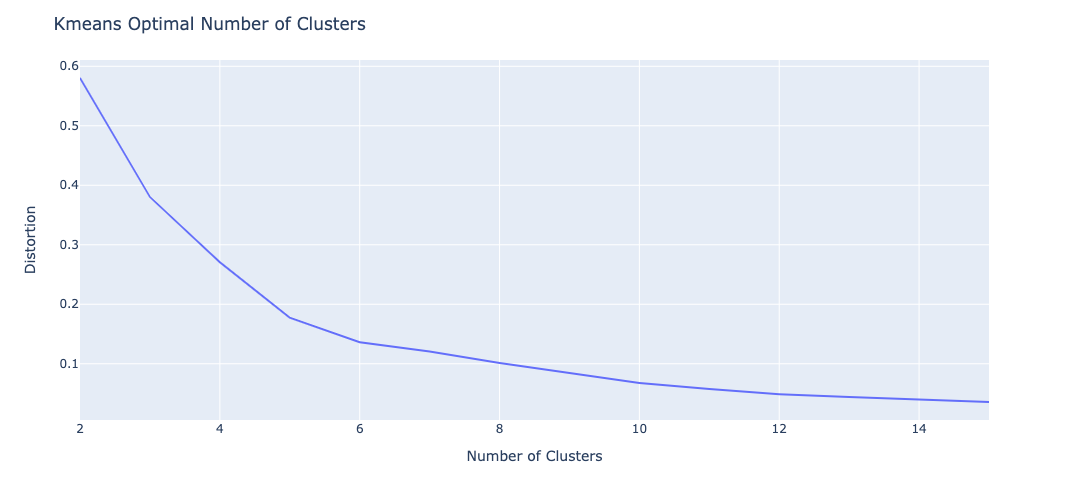

In [37]:
method='pacf'
nlags=1 # pacf method using AR(n) lags. nlags allowed values depend on dataset
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize' # normalize or min_max
split_method= None # 'rank' or 'quantitles' allowed for 'target' method
n_clusters=None # define explicitly, or allow selection based onb max silhouette score
max_clusters=15 # int or None (# series - 1)
plot=True

df_w_clusters = ts.add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       max_clusters=max_clusters, 
                                       plot=plot)

### This clustering shows an 'elbow' at 5 clusters where the slope drastically changes before and answer this point. Here we may want to force 5 clusters.

In [38]:
method='pacf'
nlags=1 # pacf method using AR(n) lags. nlags allowed values depend on dataset
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize' # normalize or min_max
split_method= None # 'rank' or 'quantitles' allowed for 'target' method
n_clusters= 5 # define explicitly, or allow selection based onb max silhouette score
max_clusters=15 # int or None (# series - 1)
plot=True

df_w_clusters =  ts.add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       max_clusters=max_clusters, 
                                       plot=plot)

/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.p

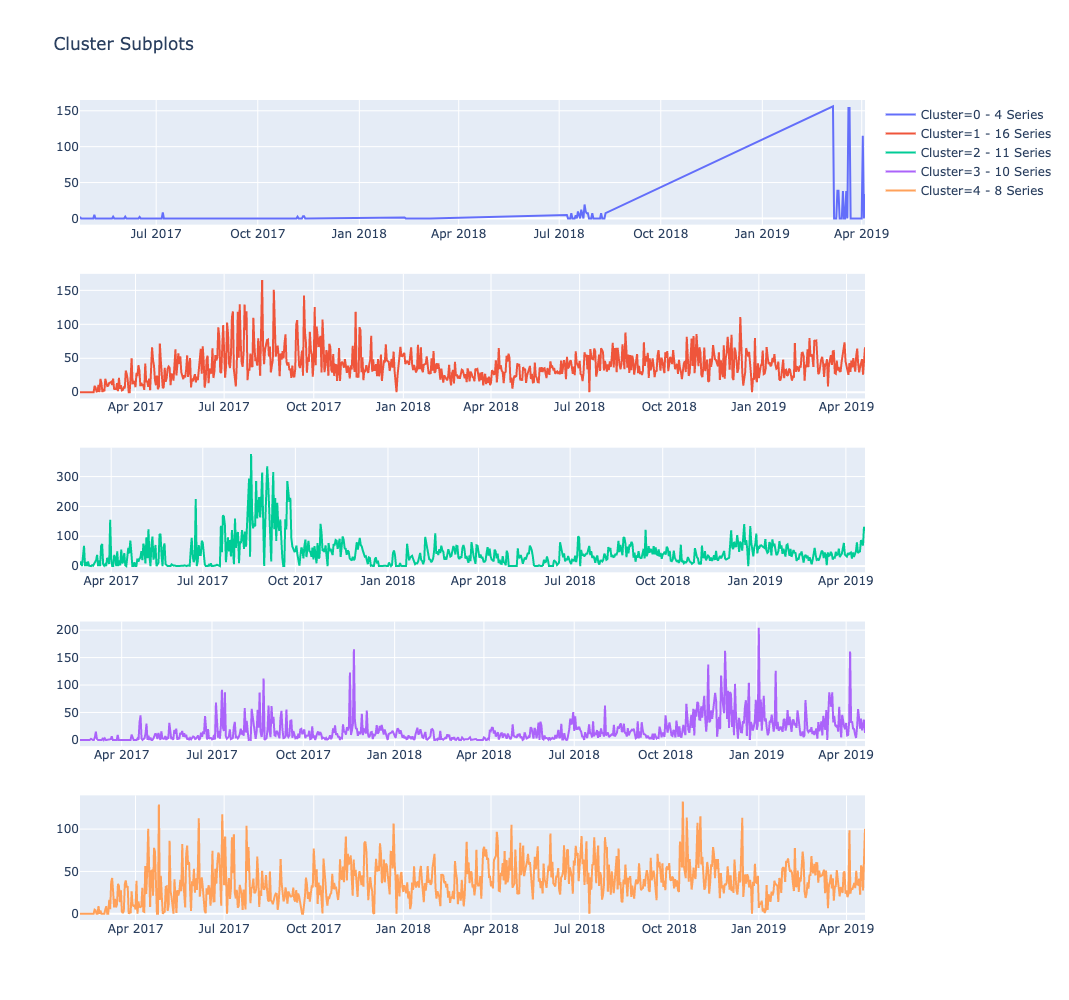

In [39]:
ts.plot_clusters(df_w_clusters, ts_settings)

In [40]:
ts.plot_UMAP(clusters_t_scaled, df_w_clusters, ts_settings)

#### These clusters do look different from each other in terms of volatility and average daily sales. Also, we see that each technique and different settings are resulting in different groupings of the series (see the number of series in each cluster in the figure legends above).

#### While an elbow-plot may suggest a number of clusters, there is no 'best' way to assign clusters that works universally. Often it requires manual examination of clustered series to see what makes most sense.

------------
### Next, we can see if the 'target' clustering yields stronger results. 'Target' clustering will perform basic analysis of the target variable for a series and either be split by the rank, quantiles or if neither of those split_methods is provided will simply analyze the mean of each series. This is one of the best approaches for retail data.

In [41]:
# target 
method='target'
nlags=None
alpha=None 
scale=True
scale_method='normalize'
n_clusters=None
split_method= 'rank' # rank or quantiles
max_clusters=5
plot=True

df_w_clusters =  ts.add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       split_method = split_method,
                                       max_clusters=max_clusters, 
                                       plot=plot)

/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.p

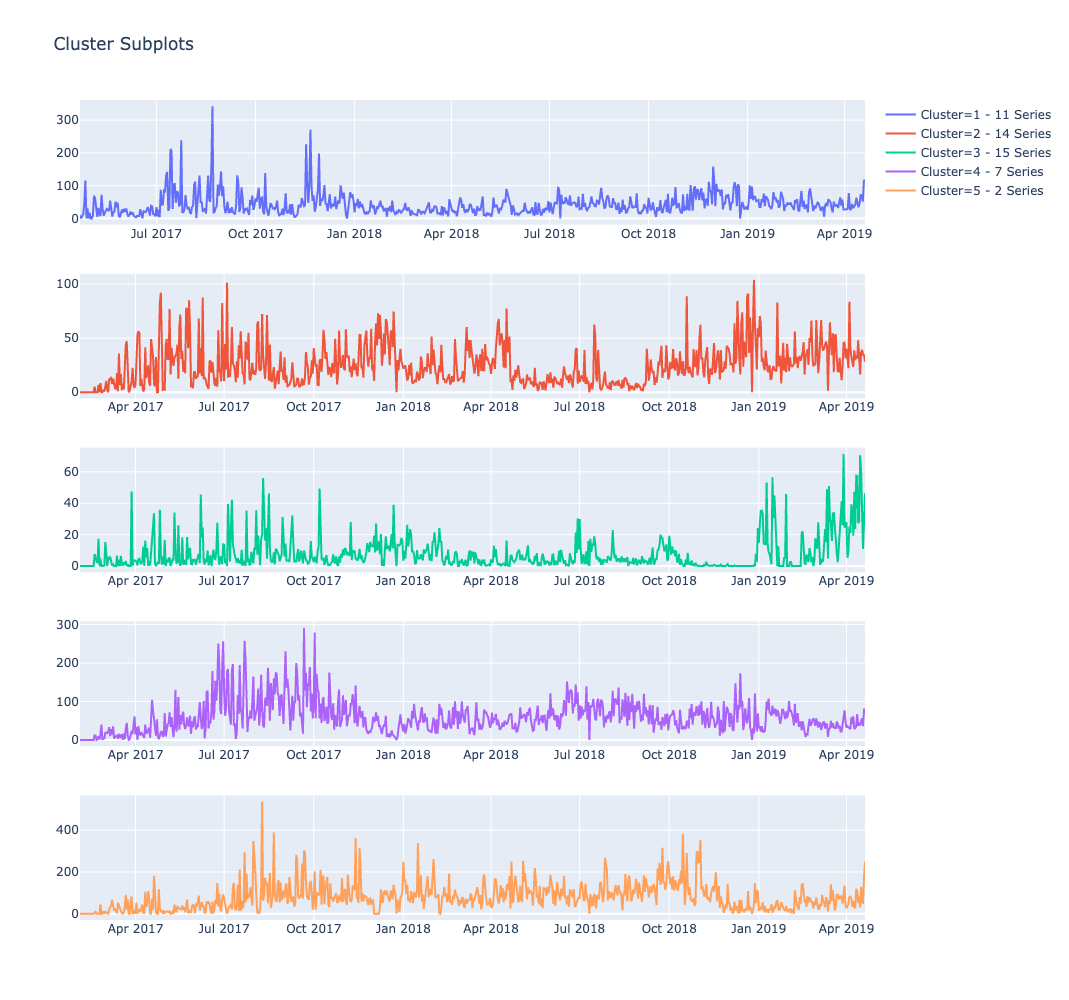

In [42]:
ts.plot_clusters(df_w_clusters, ts_settings)

In [43]:
ts.plot_UMAP(clusters_t_scaled, df_w_clusters, ts_settings)

### For this dataset, 'target' clustering yields many different clusters each with a small number of series. Without modeling, it is difficult to know how relevant these clusters are even with visual investigation.

------------
### The final clustering approaches relies upon DataRobot's 'Performance Clustering' blueprints to determine the appropriate number of clusters and assignment of series into those clusters.

#### This works well when there are MANY projects as it is quite computationally effecient to run a single project with all of the series to get cluster labels, and then subsequently run the projects separately based on the clustering from Performance blueprints

In [47]:
# currently this functionality is broken in the scripts. May be later fixed and included

# method='performance'
# nlags=1
# alpha=None #Set to None if you want keep raw coefficeints
# scale=True
# scale_method='normalize'
# n_clusters=None
# max_clusters=15
# plot=True

# df_w_clusters =  ts.add_cluster_labels(training, 
#                                        ts_settings, 
#                                        method=method,
#                                        scale=scale,
#                                        scale_method=scale_method,
#                                        alpha=alpha,
#                                        nlags=nlags, 
#                                        n_clusters=n_clusters, 
#                                        max_clusters=max_clusters, 
#                                        plot=plot)

# plot_clusters(df_w_clusters, ts_settings)

#### Enough with clustering for now, we will move forward with the following approach. We may gain insight on better clustering approaches after we've models this data in DataRobot. We can revist this later if needed as we evaluate the performance of DataRobot models. 

### Ultimately, iteration on different clustering strategies is both difficult to automate (it requires human insight) and likely will not have as large effect on the project outcome as data preparation and feature engineering or iterative modeling efforts (assuming we are using some sort of clustering).

----------------

# Cross Series Features

### In this dataset, it may be relevant to add cross series features from the other series in the same clusters

#### - The following function will create custom aggregations across groups
#### - group input is the precise label to be used with a pandas groupby function: df.groupby(group_input)
#### - group accepts multiple column names as inputs if provided in a list
#### - functions must be compatible with pandas df.transform(function) structure, which allows for user-defined functions

In [44]:
# create cross series features automatically
df_w_clusters = ts.create_cross_series_features(df_w_clusters, 
                                             group=['date','Cluster'], 
                                             cols=[target], 
                                             funcs=['mean','std','min','max'])
df_w_clusters.head(2)

item_name       date package_id_min package_id_max  package_id_unique  \
0  Milky Way 2017-04-21     1700000437     1700000437                1.0   
1  Milky Way 2017-04-22            NaN            NaN                NaN   

      campaign_min     campaign_max  campaign_unique  qty_min  qty_mean  \
0  discount_type_1  discount_type_1              1.0     1.98      2.97   
1              NaN              NaN              NaN      NaN       NaN   

   qty_max  qty_stdev  qty_unique  qty_sum  unit_price_min  unit_price_mean  \
0     3.96   1.400072         2.0     5.94            1.37             1.64   
1      NaN        NaN         NaN      NaN             NaN              NaN   

   unit_price_max  unit_price_stdev  unit_price_unique  unit_price_sum  \
0            1.91          0.381838                2.0            3.28   
1             NaN               NaN                NaN             NaN   

   sale_amount_min  sale_amount_mean  sale_amount_max  sale_amount_stdev  \
0             3.78             4.605             5.43           1.166726   
1              NaN               NaN              NaN                NaN   

   sale_amount_unique  sale_amount_sum  day store_category category  \
0                 2.0             9.21  Fri         Type_B   Retail   
1                 NaN             0.00  NaN            NaN      NaN   

  transaction  aggregated_total_count  metro_area  county_1  \
0        Good                     2.0         NaN       NaN   
1         NaN                     NaN         NaN       NaN   

   total_market_sales  Cluster  sale_amount_sum_mean  sale_amount_sum_std  \
0                 NaN        1                  9.21                  NaN   
1                 NaN        1                  0.00                  NaN   

   sale_amount_sum_min  sale_amount_sum_max  
0                 9.21                 9.21  
1                 0.00                 0.00

-----------------
# Build DataRobot Projects on Clustered Data

## Project group 2: 'Demand_forecasting_tutorial_project_2'

- Use more FDWs
- Separate the FD into separate projects
- Model on 3 clusters (assigned by correlation clustering)

In [45]:
# Series clustering
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=3
max_clusters=15
plot=True

df_w_clusters_2 =  ts.add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=plot)


df_w_clusters_2 = ts.create_cross_series_features(df_w_clusters_2, 
                                             group=['date','Cluster'], 
                                             cols=[target], 
                                             funcs=['mean','std','min','max'])

# save df for subsequent use
df_w_clusters_2.to_csv('data/project_2_data.csv')

In [50]:
# use correlation clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fdws_2 = [(-28,0), (-56,0), (-84,0)] # typically multiples of a seasonality are a good starting point
fds_2 = [(1,15), (16,30)] # in this case, predicting one month of sales is the goal

projects_2 = ts.create_dr_projects(df_w_clusters_2, 
                             ts_settings, 
                             prefix='Demand_forecasting_tutorial_project_2', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws_2, 
                             fds=fds_2, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

Kicking off 18 projects

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-28_Cluster-0 ...
Project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-28_Cluster-0 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-28_Cluster-0 ...
Project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-28_Cluster-0 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-56_Cluster-0 ...
Project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-56_Cluster-0 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-56_Cluster-0 ...
Project Demand_forecasting_tutorial_project_2_FD:16-30_FDW:-56_Cluster-0 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_2_FD:1-15_FDW:-84_Cluster-0 ...
Project Demand_for

## Project group 3: 'Demand_forecasting_tutorial_project_3'

- Use shorter FDWs
- Separate the FD into separate projects
- Model on 5 clusters (assigned by target clustering)

In [46]:
# target 
method='target'
nlags=None
alpha=None 
scale=True
scale_method='normalize'
n_clusters=None
split_method= 'rank' # rank or quantiles
max_clusters=5
plot=True

df_w_clusters_3 =  ts.add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       split_method = split_method,
                                       max_clusters=max_clusters, 
                                       plot=plot)
df_w_clusters_3 = ts.create_cross_series_features(df_w_clusters_3, 
                                             group=['date','Cluster'], 
                                             cols=[target], 
                                             funcs=['mean','std','min','max'])
# save df for subsequent use
df_w_clusters_3.to_csv('data/project_3_data.csv')

In [52]:
# use target clustering with 8 clusters
fdws_3 = [(-14,0), (-28,0), (-62,0)] # typically multiples of a seasonality are a good starting point
fds_3 = [(1,15), (16,30)] # in this case, predicting one month of sales is the goal

projects_3 = ts.create_dr_projects(df_w_clusters_3, 
                             ts_settings, 
                             prefix='Demand_forecasting_tutorial_project_3', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws_3, 
                             fds=fds_3, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

Kicking off 30 projects

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1 ...
Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-14_Cluster-1 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-1 ...
Project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-14_Cluster-1 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-1 ...
Project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-28_Cluster-1 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-28_Cluster-1 ...
Project Demand_forecasting_tutorial_project_3_FD:16-30_FDW:-28_Cluster-1 was successfully built!

Building Next Project 
...

Creating project Demand_forecasting_tutorial_project_3_FD:1-15_FDW:-62_Cluster-1 ...
Project Demand_for

## These projects will take some time to run. 

## The results from these projects will be evaluated in the next notebook: `Demand_forecasting_tutorial_model_evaluation_and_iteration.ipynb`